# Hazard Watches API

Author: stephan@bayes.org

Guillaume (guillaume@bayes.org) spent some time looking over all the data sources mentioned [here](https://drive.google.com/open?id=0B4qjio_turGRMnlDMVZ6WVp5SGM) and found that the _Watches Warnings_ endpoint could be a good choice for our prototype. It contains warnings for many different hazards (Blizzard, Ash Fall, Fire, Flood, ...) in the form of polygons covering the area in danger, not only points as some of the other endpoints. We decided to use this endpoint for our application. 

This notebook investigates properties of the data coming from this endpoint and described the processing steps that have to be applied before the data can be imported into our database.

We are goint to extract _watches_ from the API. A watch is used when the risk of a hazardous weather or hydrologic event has increased significantly, but its occurrence, location, and/or timing is still uncertain. It is intended to provide enough lead time so that those who need to set their plans in motion can do so. More details can be found [here](https://idpgis.ncep.noaa.gov/arcgis/rest/services/NWS_Forecasts_Guidance_Warnings/watch_warn_adv/MapServer).

In [1]:
import json

import arcgis
from IPython import display
import pandas as pd
from shapely import geometry

gis = arcgis.gis.GIS()

# For an explanation see markdown cell below.
SIMPLIFICATION_TOLERANCE = 0.05

API_URL = 'https://idpgis.ncep.noaa.gov/arcgis/rest/services/NWS_Forecasts_Guidance_Warnings/watch_warn_adv/MapServer/1'
WATCHES_JSON_PATH = '../data/watches.json'

The following query crashes most of the time with a 500. I did some research and found that the problem is most likely a setting in their server. They have to give it more RAM in order to respond to such a large query. I contacted (Feb 28, 2017) several people at NOAA and hope to hear back from them soon. Luckily the query once ran through and I saved the output of it. You can download `watches.json`, produced by the query below, from our [google drive](https://drive.google.com/drive/folders/0B0HVZcvtNA6cWlNKRkhYLXlwSms?usp=sharing). 

In [2]:
# TODO: Uncomment once the API is fixed.
# layer = arcgis.features.FeatureLayer(API_URL, gis)
# events = [e.as_dict for e in layer.query().features]

In [3]:
watches = json.load(open(WATCHES_JSON_PATH))
print('%d watches loaded from API' % len(watches))

594 watches loaded from API


In [4]:
watches_attrs = pd.DataFrame([watch['attributes'] for watch in watches])
watches_attrs.head(2).transpose()

,0,1
event,0037,0036
expiration,2017-02-28 03:00:00,2017-02-27 15:00:00
idp_current_forecast,None,None
idp_fcst_hour,None,None
idp_filedate,1488205501000,1488205501000
idp_ingestdate,1488202096000,1488202096000
idp_issueddate,1488171540000,1488171540000
idp_source,current_hazards,current_hazards
idp_subset,default,default
idp_time_series,None,None


### What are the most common hazards?

In [5]:
watches_attrs.prod_type.value_counts()

Fire Weather Watch                         99
Winter Weather Advisory                    98
Small Craft Advisory                       70
High Wind Watch                            65
Hydrologic Statement                       61
Dense Fog Advisory                         56
Fire Weather Warning                       40
Winter Storm Warning                       24
Flood Warning                              23
Small Craft for Hazardous Seas Advisory    11
Wind Advisory                               8
Flood Watch                                 7
Flash Flood Watch                           5
Hazardous Seas Warning                      4
Small Craft for Winds Advisory              3
Areal Flood Warning                         3
Rip Current Statement                       3
Small Craft for Rough Bar Advisory          2
Areal Flood Advisory                        2
Areal Flood Watch                           2
Flood Advisory                              2
High Wind Warning                 

Let's have a closer look at the geometric shape of those watches.

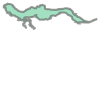

Small Craft for Rough Bar Advisory


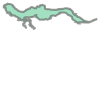

Small Craft for Rough Bar Advisory


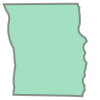

Small Craft for Winds Advisory


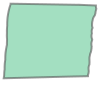

Small Craft for Winds Advisory


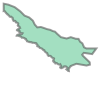

Winter Weather Advisory


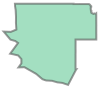

Winter Weather Advisory


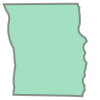

Small Craft for Hazardous Seas Advisory


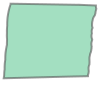

Small Craft for Hazardous Seas Advisory


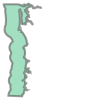

Small Craft for Hazardous Seas Advisory


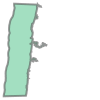

Small Craft for Hazardous Seas Advisory


In [6]:
for watch in watches[:10]:
    display.display(geometry.Polygon(watch['geometry']['rings'][0]))
    print(watch['attributes']['prod_type'])

Those shapes look very detailed, which probably accounts for the size of the data returned from the API. I want to use those polygons to draw them on the map. The file without simplification has a size of 30MB and I want to avoid transferring such an amount of data when the application is loaded. Let's see if we need so much detail for our application. 

In [7]:
len(watches[0]['geometry']['rings'][0])

2364

Polygons have a very high resolution

In [8]:
len(watches[3]['geometry']['rings'][0])

276

Even simple shapes have a pretty high resolution.

Let's do something against this, using `shapely` to simplify the polygons. 

All points in the simplified object will be within the _tolerance distance_ of the original geometry. In our case I arbitrarily decided that we want a tolerance that is within a range of 5 miles.

The distances between degrees of latitude are almost constant and are about 69 miles apart. 
The distances between degrees of longitude vary between around 69 miles at the equator and zero at the poles. At the northern end of the US it is something around 50 miles. 

So if we choose the tolerance to be 0.05 degrees, we are always within < 3.5 miles of error.

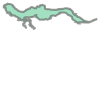

The original polygon has 2364 points


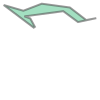

The simplified polygon has 13 points


In [9]:
def shapely_coords_to_list(shaply_coords):
    return list(zip(shaply_coords[0], shaply_coords[1]))

polygon = geometry.Polygon(watches[0]['geometry']['rings'][0])
simplified_polygon = polygon.simplify(SIMPLIFICATION_TOLERANCE)
display.display(polygon)
print('The original polygon has %d points' % len(watches[0]['geometry']['rings'][0]))
display.display(simplified_polygon)
print('The simplified polygon has %d points' % len(shapely_coords_to_list(simplified_polygon.exterior.coords.xy)))


That still looks reasonable and will make the size of the dataset to be imported into our database much smaller.

## Conclusion

* Once the API gets fixed this sounds like a good source to get shapes of hazards for our application.
* Each _watch_ has metadata like the issuance or expiration attached.

Next steps:

* Find out how often these _watches_ get updated to determine how often our backend should query the endpoint. 
* Do analysis to get a better understanding of the dataset, for example:
    * How long is a watch usually valid?
    * Can we get further information out of the URLs attached?
    * ...